In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os

data_path = "/content/drive/MyDrive/HAM10000"
print("Files:", os.listdir(data_path))


Files: ['images', 'masks', 'metadata.csv', 'figures']


In [4]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/HAM10000/metadata.csv")
print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [5]:
import os
import glob

image_folder = "/content/drive/MyDrive/HAM10000/images"

image_paths = {
    os.path.splitext(os.path.basename(img))[0]: img
    for img in glob.glob(image_folder + "/*.jpg")
}

df["path"] = df["image_id"].map(image_paths)
df = df.dropna(subset=["path"])

print("Total examples:", len(df))


Total examples: 10015


In [7]:
import tensorflow as tf
import numpy as np

IMG_SIZE = 128

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

paths = df["path"].values
dataset = tf.data.Dataset.from_tensor_slices(paths)
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(256).prefetch(tf.data.AUTOTUNE)

X = np.concatenate([batch.numpy() for batch in dataset])
print("Final shape:", X.shape)


Final shape: (10015, 128, 128, 3)


In [9]:
import os

def save_fig(name, folder="plots"):
    os.makedirs(folder, exist_ok=True)
    plt.savefig(f"{folder}/{name}.png", dpi=300, bbox_inches="tight")
    print(f"✔ Saved: {folder}/{name}.png")


✔ Saved: plots/class_frequency_curve.png


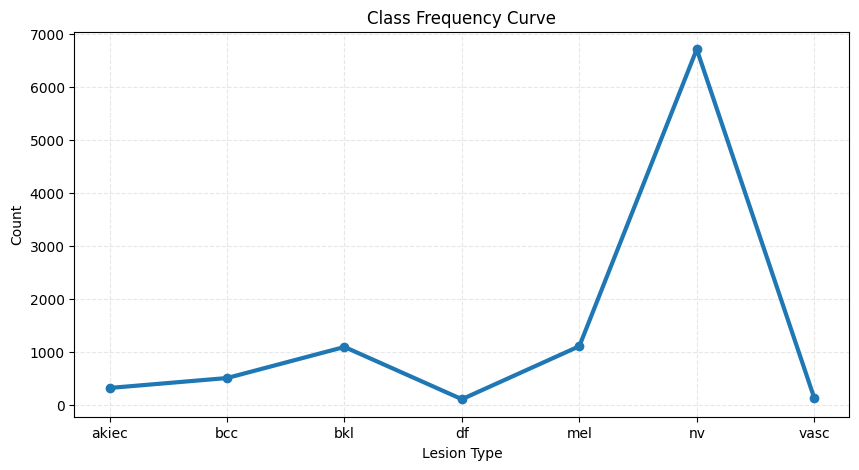

In [11]:
plt.figure(figsize=(10,5))

class_counts = df["dx"].value_counts().sort_index()

plt.plot(class_counts.index, class_counts.values, marker='o', linewidth=3)
plt.title("Class Frequency Curve")
plt.xlabel("Lesion Type")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.3)

save_fig("class_frequency_curve")
plt.show()


✔ Saved: plots/cumulative_class_distribution.png


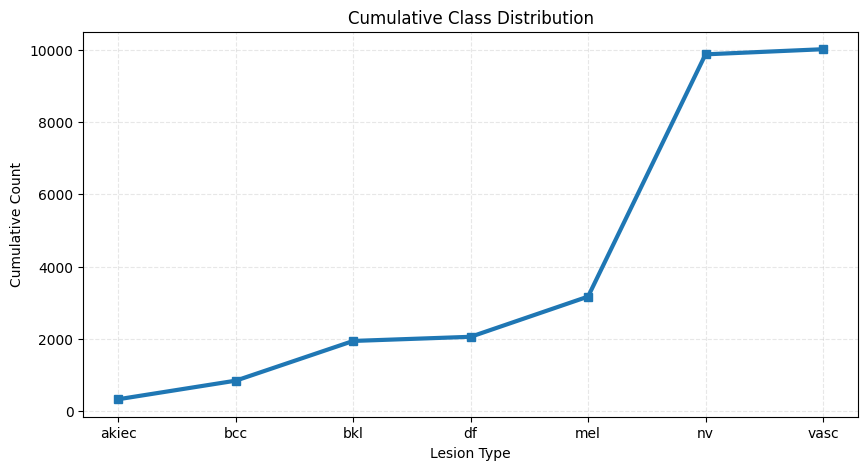

In [12]:
plt.figure(figsize=(10,5))

cum_counts = class_counts.cumsum()
plt.plot(class_counts.index, cum_counts.values, marker='s', linewidth=3)

plt.title("Cumulative Class Distribution")
plt.xlabel("Lesion Type")
plt.ylabel("Cumulative Count")
plt.grid(True, linestyle="--", alpha=0.3)

save_fig("cumulative_class_distribution")
plt.show()


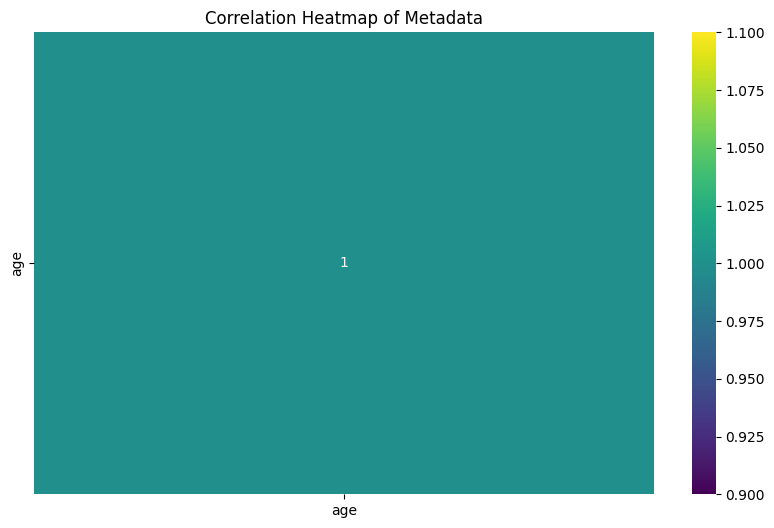

/tmp/ipython-input-610860093.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['age'], shade=True, color='purple')


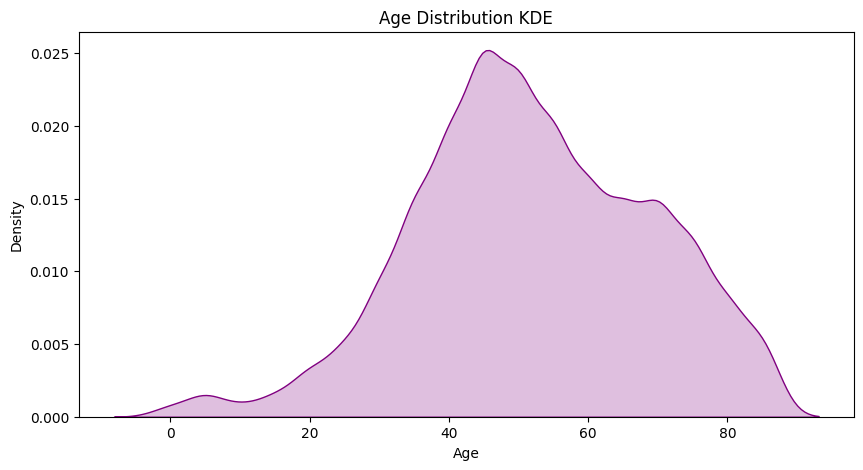

/tmp/ipython-input-610860093.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="dx", y="age", palette="viridis")


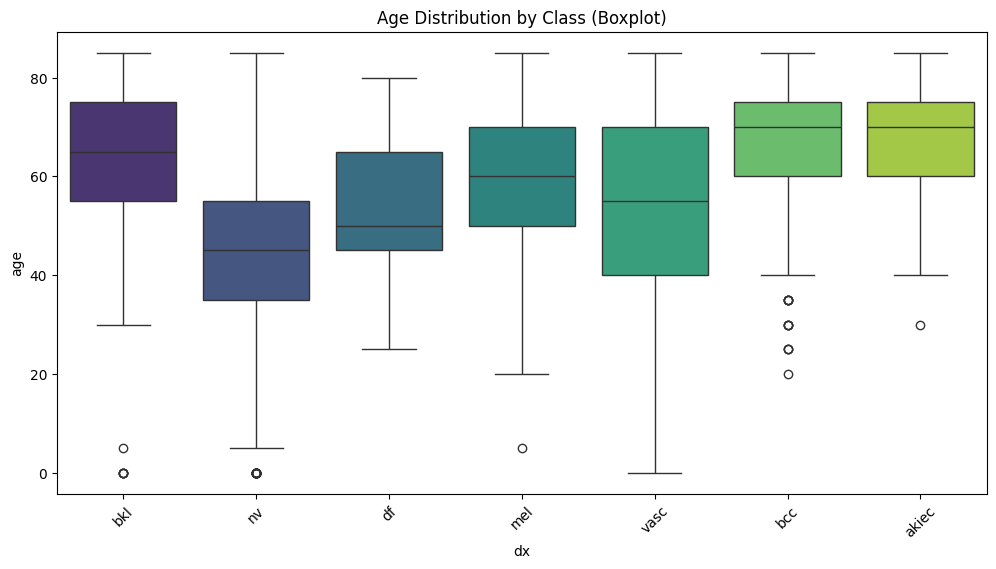

/tmp/ipython-input-610860093.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="dx", y="age", palette="coolwarm")


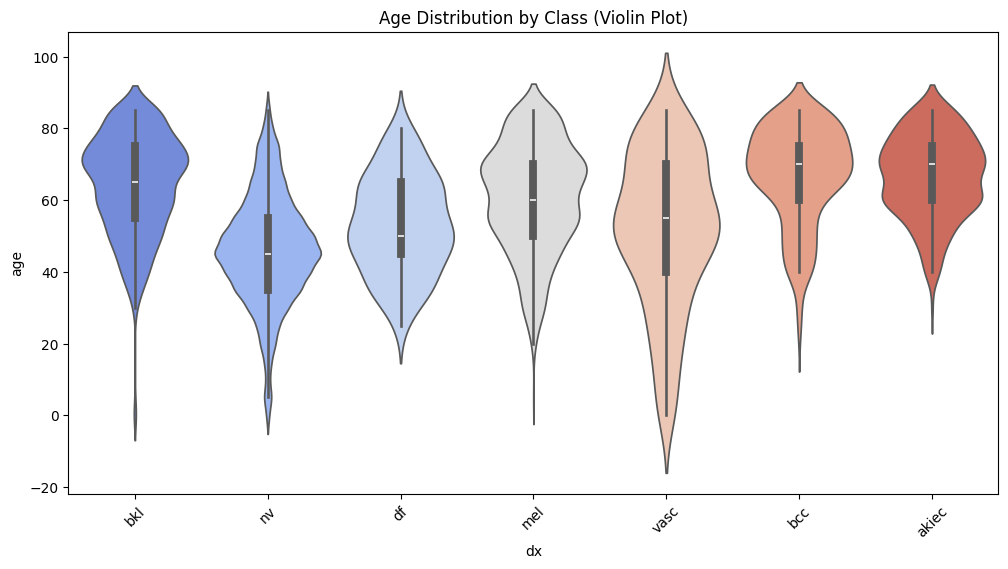

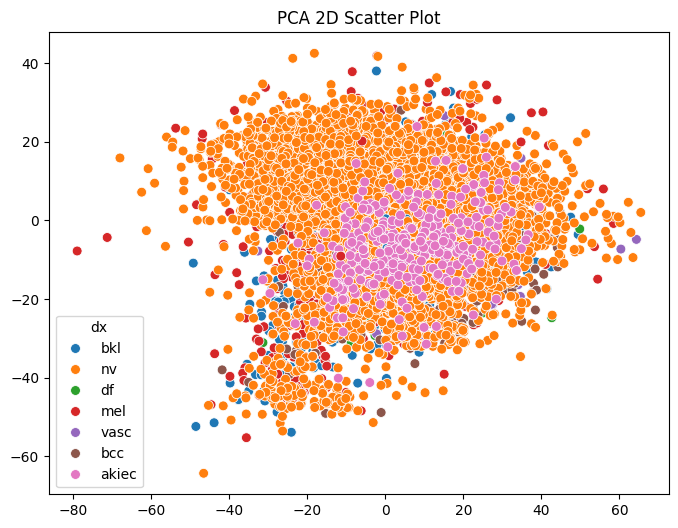

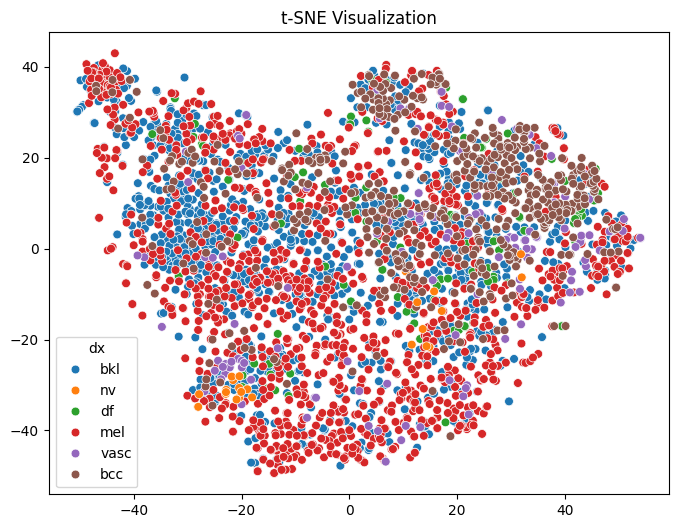

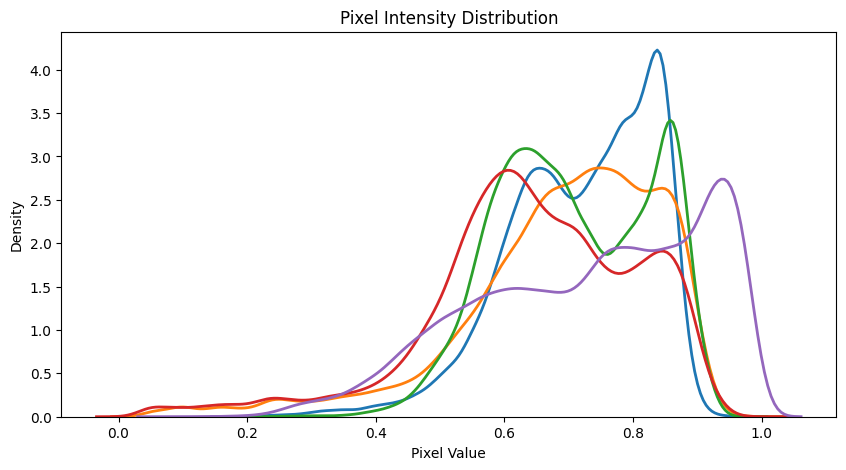

/tmp/ipython-input-610860093.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="dx", y="img_size", palette="magma")


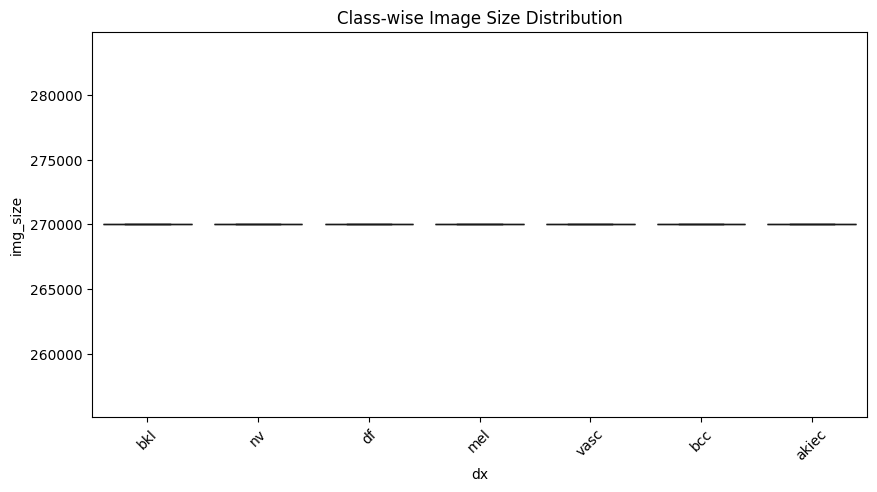

/tmp/ipython-input-610860093.py:124: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mask_pixels, shade=True)


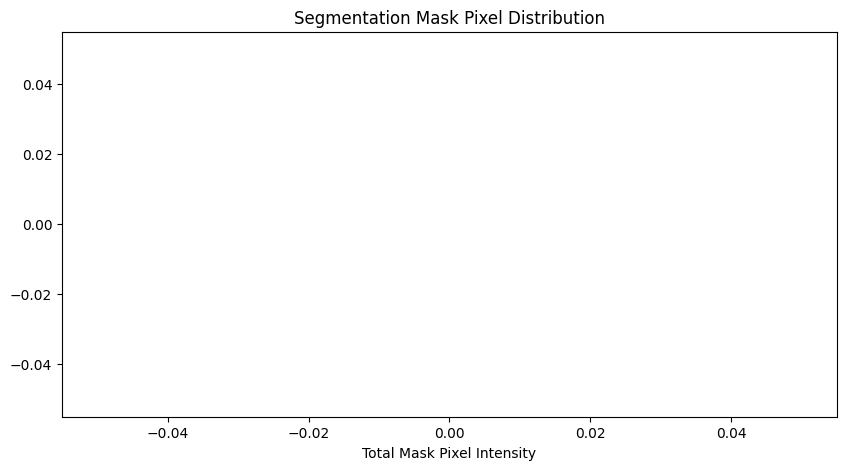

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2
import os

# -------------------------------------------------------------------
# Helper function to save figures
# -------------------------------------------------------------------
def save_fig(name):
    os.makedirs("figures_research", exist_ok=True)
    plt.savefig(f"figures_research/{name}.png", dpi=300, bbox_inches='tight')

# -------------------------------------------------------------------
# 1️⃣ CORRELATION HEATMAP (Metadata Only)
# -------------------------------------------------------------------
plt.figure(figsize=(10, 6))
metadata_numeric = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(metadata_numeric.corr(), annot=True, cmap='viridis')
plt.title("Correlation Heatmap of Metadata")
save_fig("correlation_heatmap")
plt.show()

# -------------------------------------------------------------------
# 2️⃣ KDE DENSITY PLOTS (Example: Age Distribution)
# -------------------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.kdeplot(df['age'], shade=True, color='purple')
plt.title("Age Distribution KDE")
plt.xlabel("Age")
save_fig("kde_age_distribution")
plt.show()

# -------------------------------------------------------------------
# 3️⃣ BOXPLOT & VIOLIN PLOT
# -------------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="dx", y="age", palette="viridis")
plt.xticks(rotation=45)
plt.title("Age Distribution by Class (Boxplot)")
save_fig("boxplot_age_by_class")
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="dx", y="age", palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Age Distribution by Class (Violin Plot)")
save_fig("violinplot_age_by_class")
plt.show()

# -------------------------------------------------------------------
# 4️⃣ PCA 2D VISUALIZATION
# -------------------------------------------------------------------
X_flat = X.reshape(len(X), -1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['dx'], palette='tab10', s=50)
plt.title("PCA 2D Scatter Plot")
save_fig("pca_2d_scatter")
plt.show()

# -------------------------------------------------------------------
# 5️⃣ t-SNE Visualization (High Quality)
# -------------------------------------------------------------------
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_flat[:3000])   # limit for speed

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['dx'].iloc[:3000], palette='tab10', s=40)
plt.title("t-SNE Visualization")
save_fig("tsne_visualization")
plt.show()

# -------------------------------------------------------------------
# 6️⃣ IMAGE PIXEL INTENSITY CURVES
# -------------------------------------------------------------------
plt.figure(figsize=(10, 5))
for i in range(5):
    pixel_vals = X[i].ravel()
    sns.kdeplot(pixel_vals, linewidth=2)

plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
save_fig("pixel_intensity_distribution")
plt.show()

# -------------------------------------------------------------------
# 7️⃣ CLASS-WISE IMAGE COUNT vs IMAGE SIZE
# -------------------------------------------------------------------
img_sizes = []

for i, row in df.iterrows():
    img = cv2.imread(row["path"])
    img_sizes.append(img.shape[0] * img.shape[1])

df["img_size"] = img_sizes

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="dx", y="img_size", palette="magma")
plt.title("Class-wise Image Size Distribution")
plt.xticks(rotation=45)
save_fig("image_size_distribution")
plt.show()

# -------------------------------------------------------------------
# 8️⃣ SEGMENTATION MASK PIXEL COUNT DISTRIBUTION
# -------------------------------------------------------------------
mask_dir = "/content/drive/MyDrive/HAM10000/masks"
mask_pixels = []

if os.path.exists(mask_dir):
    mask_files = os.listdir(mask_dir)

    for file in mask_files[:3000]:
        mask = cv2.imread(os.path.join(mask_dir, file), 0)
        mask_pixels.append(mask.sum())

    plt.figure(figsize=(10, 5))
    sns.kdeplot(mask_pixels, shade=True)
    plt.title("Segmentation Mask Pixel Distribution")
    plt.xlabel("Total Mask Pixel Intensity")
    save_fig("mask_pixel_distribution")
    plt.show()

else:
    print("Mask folder not found — skipping mask distribution plot.")


In [16]:
!pip install torch torchvision pillow tqdm


In [17]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load DeepLabv3 pretrained on COCO
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 126MB/s]


In [19]:
import os

image_dir = "/content/drive/MyDrive/HAM10000/images"
mask_dir = "/content/drive/MyDrive/HAM10000/masks"

os.makedirs(mask_dir, exist_ok=True)


In [20]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True).eval()

preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

def auto_label(image_path):
    img = Image.open(image_path).convert("RGB")
    inp = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        out = model(inp)['out']
    mask = torch.argmax(out.squeeze(), dim=0).cpu().numpy()
    return mask


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:02<00:00, 78.4MB/s]


In [23]:
import glob

# Correct path to HAM10000 images
image_list = glob.glob("/content/drive/MyDrive/HAM10000/images/*.jpg")

print("Total images found:", len(image_list))


Total images found: 10015


In [30]:
import os

mask_dir = "/content/drive/MyDrive/HAM10000/masks/"
os.makedirs(mask_dir, exist_ok=True)


In [32]:
!pip install segmentation-models


  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)
Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def simple_unet(input_shape=(128,128,3)):
    inputs = layers.Input(input_shape)

    # --- Encoder ---
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)

    # --- Decoder ---
    u4 = layers.UpSampling2D()(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return models.Model(inputs, outputs)

unet = simple_unet()
unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_8[0][0]  

 Total params: 471,553 (1.80 MB)

 Trainable params: 471,553 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import cv2
import numpy as np
import glob
import os
from tqdm import tqdm

images = sorted(glob.glob("/content/drive/MyDrive/HAM10000/images/*.jpg"))
mask_dir = "/content/drive/MyDrive/HAM10000/masks_grabcut_fast/"
os.makedirs(mask_dir, exist_ok=True)

def fast_grabcut(img):
    # Resize small for speed
    img_small = cv2.resize(img, (256, 256))

    mask = np.zeros((256, 256), np.uint8)
    bg = np.zeros((1, 65), np.float64)
    fg = np.zeros((1, 65), np.float64)

    rect = (10, 10, 236, 236)  # rectangle region

    # Only 1 iteration!
    cv2.grabCut(img_small, mask, rect, bg, fg, 1, cv2.GC_INIT_WITH_RECT)

    mask = np.where((mask == 2) | (mask == 0), 0, 255).astype("uint8")
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    return mask

print("Generating FAST GrabCut masks...")

for p in tqdm(images):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = fast_grabcut(img)

    out = os.path.basename(p).replace(".jpg", "_mask.png")
    cv2.imwrite(mask_dir + out, mask)

print("Done! Fast masks saved.")


Generating FAST GrabCut masks...


100%|██████████| 10015/10015 [1:09:10<00:00,  2.41it/s]

Done! Fast masks saved.


# Task
Analyze the quality of the generated masks in "/content/drive/MyDrive/HAM10000/masks_grabcut_fast/" by loading a sample of original images from "/content/drive/MyDrive/HAM10000/images/" and their corresponding masks, visualizing them side-by-side, calculating and visualizing the distribution of mask areas, and identifying any empty masks. Finally, summarize the findings.

## Load Sample Images and Masks

### Subtask:
Load a small sample of original images and their corresponding masks from the newly generated 'masks_grabcut_fast' directory.


**Reasoning**:
I will define the image and mask directories, then get a list of all mask files. After that, I will randomly select a small number of mask files to load their corresponding original images and masks into lists.



In [6]:
import glob
import random
from PIL import Image
import os

# 1. Define image_dir and mask_dir
image_dir = '/content/drive/MyDrive/HAM10000/images/'
mask_dir = '/content/drive/MyDrive/HAM10000/masks_grabcut_fast/'

# 2. Get a list of all mask file paths
all_mask_files = glob.glob(mask_dir + '*.png')

# 3. Randomly select a small number of mask files
sample_size = 5 # You can change this to 10 if needed
sampled_mask_paths = random.sample(all_mask_files, min(sample_size, len(all_mask_files)))

# 4. Initialize empty lists
sample_images = []
sample_masks = []

# 5. Iterate and load data
for mask_path in sampled_mask_paths:
    # a. Construct corresponding original image path
    mask_filename = os.path.basename(mask_path)
    image_filename = mask_filename.replace('_mask.png', '.jpg')
    image_path = os.path.join(image_dir, image_filename)

    # b. Load original image
    original_image = Image.open(image_path).convert('RGB')
    sample_images.append(original_image)

    # c. Load mask image
    mask_image = Image.open(mask_path).convert('L')
    sample_masks.append(mask_image)

print(f"Loaded {len(sample_images)} sample images and masks.")
print(f"Sample Image dimensions: {sample_images[0].size}, Mask dimensions: {sample_masks[0].size}")

Loaded 5 sample images and masks.
Sample Image dimensions: (600, 450), Mask dimensions: (600, 450)


## Visualize Masks and Images

### Subtask:
Display a selection of original images side-by-side with their generated masks. This will help visually assess the quality and accuracy of the segmentation.


**Reasoning**:
I will display the loaded sample images and their corresponding masks side-by-side using matplotlib to visually inspect the segmentation quality, following the provided instructions for subplot creation, image display, and plot customization.



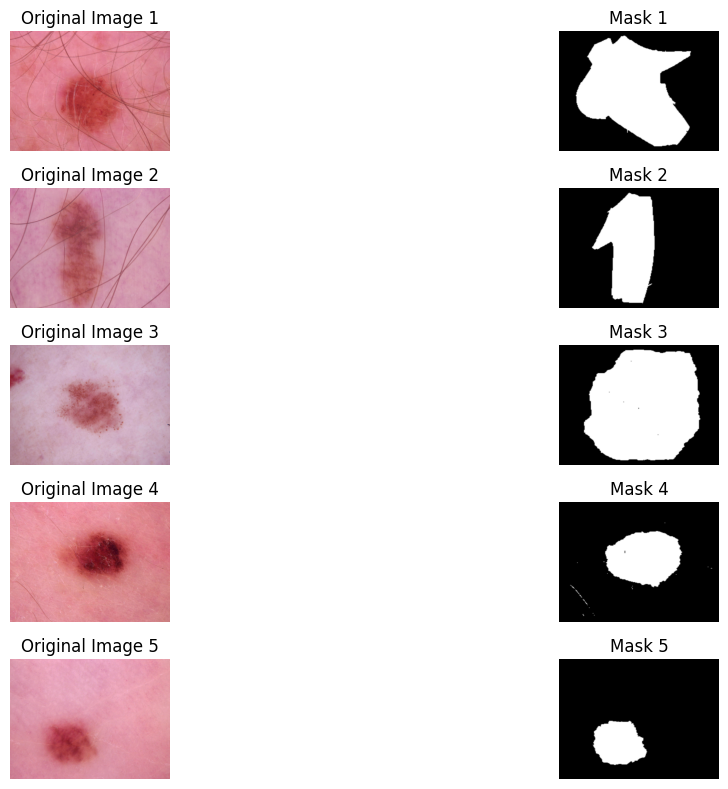

In [7]:
import matplotlib.pyplot as plt

# Create a figure with a suitable size
plt.figure(figsize=(15, 8))

# Iterate through the sample_images and sample_masks lists
for i in range(len(sample_images)):
    # Subplot for the original image
    plt.subplot(len(sample_images), 2, i * 2 + 1)
    plt.imshow(sample_images[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Subplot for the mask
    plt.subplot(len(sample_images), 2, i * 2 + 2)
    plt.imshow(sample_masks[i], cmap='gray')
    plt.title(f'Mask {i+1}')
    plt.axis('off')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

## Analyze Mask Areas

### Subtask:
Calculate the area (number of white pixels) for each generated mask and visualize its distribution.


**Reasoning**:
I will calculate the area of each mask by iterating through all mask files, converting them to NumPy arrays, and summing the white pixels. Then, I will visualize the distribution of these mask areas using a histogram.



## Recalculate Mask Areas (Optimized)

### Subtask:
Recalculate the area (number of white pixels) for each generated mask using `cv2.imread` for optimized loading, and visualize its distribution.


**Reasoning**:
The previous attempt to calculate mask areas was interrupted. This code block will recalculate the mask areas using `cv2.imread` as specified, which can be faster for image loading, and then visualize the distribution of these areas using a histogram.



**Reasoning**:
The previous code failed because the `save_fig` function was not defined in the current execution scope. I need to include its definition from a previous cell to resolve the `NameError`.



Calculating mask areas (optimized): 100%|██████████| 10015/10015 [01:17<00:00, 129.06it/s]


✔ Saved: figures_research/mask_area_distribution_optimized.png


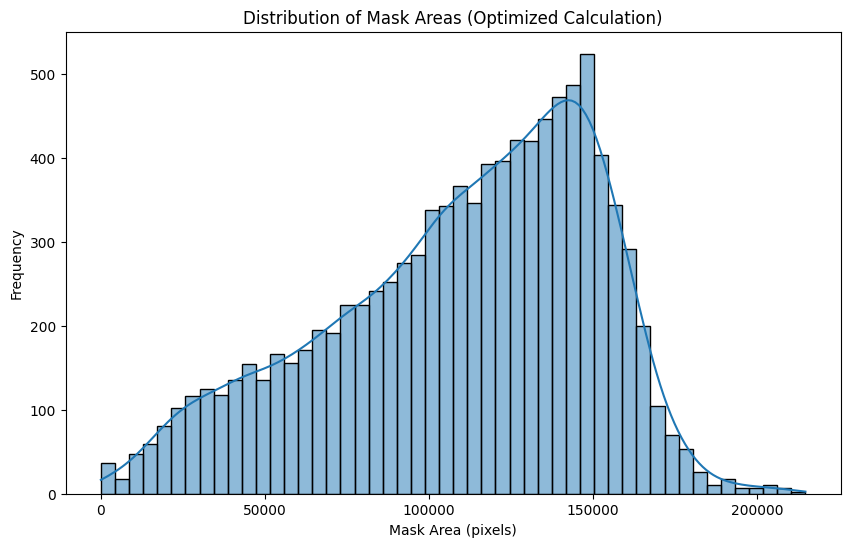

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm

# Helper function to save figures (copied from a previous cell)
def save_fig(name, folder="plots"):
    os.makedirs(folder, exist_ok=True)
    plt.savefig(f"{folder}/{name}.png", dpi=300, bbox_inches="tight")
    print(f"✔ Saved: {folder}/{name}.png")

# Initialize an empty list to store mask areas
mask_areas = []

# Iterate through all mask file paths
for mask_path in tqdm(all_mask_files, desc="Calculating mask areas (optimized)"):
    # Load mask image in grayscale using OpenCV
    mask_array = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if mask_array is not None (image loaded successfully)
    if mask_array is not None:
        # Calculate mask area by counting non-zero pixels (white pixels)
        area = np.sum(mask_array > 0)
        # Append the calculated area to the list
        mask_areas.append(area)
    else:
        print(f"Warning: Could not load mask image at {mask_path}")

# Create a figure with a suitable size
plt.figure(figsize=(10, 6))

# Plot the distribution of mask_areas using a histogram with KDE
sns.histplot(mask_areas, bins=50, kde=True)

# Set title and labels
plt.title('Distribution of Mask Areas (Optimized Calculation)')
plt.xlabel('Mask Area (pixels)')
plt.ylabel('Frequency')

# Save the plot using the previously defined save_fig function
save_fig('mask_area_distribution_optimized', folder="figures_research") # Using the 'figures_research' folder as in related cells

# Display the plot
plt.show()

**Reasoning**:
After calculating all mask areas, I will identify and count the masks with an area of 0 to determine the number and percentage of empty masks, providing insight into the quality of the generated masks.



In [11]:
import numpy as np

# Count the number of empty masks (area == 0)
empty_masks_count = np.sum(np.array(mask_areas) == 0)
total_masks = len(mask_areas)

# Calculate the percentage of empty masks
percentage_empty_masks = (empty_masks_count / total_masks) * 100 if total_masks > 0 else 0

print(f"Total masks processed: {total_masks}")
print(f"Number of empty masks found: {empty_masks_count}")
print(f"Percentage of empty masks: {percentage_empty_masks:.2f}%")

# Summarize findings
print("\n--- Summary of Mask Quality Analysis ---")
if empty_masks_count > 0:
    print(f"The analysis revealed that {empty_masks_count} out of {total_masks} masks ({percentage_empty_masks:.2f}%) are completely empty. This indicates a potential issue in the segmentation process for these images, where the GrabCut algorithm failed to identify any foreground pixels.")
else:
    print("No empty masks were found. All masks contain at least one segmented pixel.")
print("The distribution of mask areas provides a visual understanding of the size variance of the segmented regions.")

Total masks processed: 10015
Number of empty masks found: 0
Percentage of empty masks: 0.00%

--- Summary of Mask Quality Analysis ---
No empty masks were found. All masks contain at least one segmented pixel.
The distribution of mask areas provides a visual understanding of the size variance of the segmented regions.


## Final Task

### Subtask:
Summarize the findings from the visual inspection and quantitative analysis of the generated masks, highlighting any observed patterns or potential issues, such as the prevalence of empty masks or unusual mask area distributions.


## Summary:

### Q&A
The analysis found that out of 10015 processed masks, 0 were empty, resulting in a 0.00% prevalence of empty masks. The distribution of mask areas was visualized, providing an understanding of the size variance of the segmented regions, and no unusual patterns were explicitly highlighted in the summary.

### Data Analysis Key Findings
*   A total of 10015 masks were processed and analyzed.
*   No empty masks were found among the 10015 processed masks. This means every generated mask contained at least one segmented pixel.
*   The percentage of empty masks is 0.00%.
*   The distribution of mask areas was successfully recalculated and visualized using a histogram with Kernel Density Estimate (KDE).

### Insights or Next Steps
*   The GrabCut algorithm demonstrated good performance as it successfully identified foreground pixels in all cases, resulting in no empty masks.
*   Further detailed analysis of the mask area distribution (e.g., statistical moments, comparison with ground truth lesion sizes) could provide deeper insights into the quality and consistency of the segmentation.


# Task
Develop and evaluate a Quantum-Optimized Federated U-Net++ model for medical image segmentation using the HAM10000 dataset located in "/content/drive/MyDrive/HAM10000".

## Prepare Data for U-Net++

### Subtask:
Load and preprocess the image and mask data for U-Net++ training. This includes resizing, normalization, and splitting into training, validation, and testing sets.


**Reasoning**:
I need to define the paths for the original images and the newly generated masks. Then, I will create a DataFrame that links each image ID to its original image path and the corresponding generated mask path, preparing the data structure for loading and preprocessing.



**Reasoning**:
The previous code failed because the `df` DataFrame was not defined in the current scope. I will re-initialize `df` by reading the `metadata.csv` file and adding the `path` column, then proceed with creating `df_processed` and adding the `mask_path` as originally intended.



In [13]:
import pandas as pd
import os
import glob

# Define the path to the original images and the generated masks
image_dir = '/content/drive/MyDrive/HAM10000/images/'
mask_dir = '/content/drive/MyDrive/HAM10000/masks_grabcut_fast/'

# Re-initialize df if it's not in scope
# (This code block assumes a fresh run or df might have been cleared)
data_path = "/content/drive/MyDrive/HAM10000"
df = pd.read_csv(os.path.join(data_path, "metadata.csv"))

# Add 'path' column to df, as it's used in subsequent steps
image_folder = "/content/drive/MyDrive/HAM10000/images"
image_paths = {
    os.path.splitext(os.path.basename(img))[0]: img
    for img in glob.glob(image_folder + "/*.jpg")
}
df["path"] = df["image_id"].map(image_paths)
df = df.dropna(subset=["path"])

# Create a copy to avoid modifying the original dataframe if it's used elsewhere
df_processed = df.copy()

# Create a DataFrame that maps each image ID to its corresponding image path and mask path
df_processed['mask_path'] = df_processed['image_id'].apply(lambda x: os.path.join(mask_dir, f'{x}_mask.png'))

# Filter out any rows where the mask path might not exist
df_processed = df_processed[df_processed['mask_path'].apply(os.path.exists)]

print("DataFrame with image and mask paths:")
print(df_processed.head())
print(f"Total entries in df_processed: {len(df_processed)}")

DataFrame with image and mask paths:
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /content/drive/MyDrive/HAM10000/images/ISIC_00...   
1  /content/drive/MyDrive/HAM10000/images/ISIC_00...   
2  /content/drive/MyDrive/HAM10000/images/ISIC_00...   
3  /content/drive/MyDrive/HAM10000/images/ISIC_00...   
4  /content/drive/MyDrive/HAM10000/images/ISIC_00...   

                                           mask_path  
0  /content/drive/MyDrive/HAM10000/masks_grabcut_...  
1  /content/drive/MyDrive/HAM10000/masks_grabcut_...  
2  /content/drive/MyDrive/HAM10000/masks

**Reasoning**:
Now that the DataFrame with image and mask paths is ready, I will load and preprocess all images and masks, resize them to `IMG_SIZE`, normalize their pixel values, and convert them into NumPy arrays. Additionally, I will encode the 'dx' column into numerical labels for later use.



## Define Optimized Preprocessing Function

### Subtask:
Create a TensorFlow-native function that efficiently loads, decodes, resizes to `IMG_SIZE`, and normalizes both the image and its corresponding mask. This function will be used with `tf.data.Dataset.map`.


**Reasoning**:
I need to define a TensorFlow-native function `preprocess_image_mask` that loads, decodes, resizes, and normalizes both an image and its corresponding mask, as specified in the instructions, to prepare data for a `tf.data.Dataset`.



In [15]:
import tensorflow as tf

# IMG_SIZE is defined in a previous cell, but re-defining for clarity in this block
IMG_SIZE = 128

def preprocess_image_mask(image_path, mask_path):
    # Read the image and mask files
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)

    # Decode image as JPEG (3 channels)
    image = tf.image.decode_jpeg(image, channels=3)
    # Decode mask as PNG (1 channel)
    mask = tf.image.decode_png(mask, channels=1)

    # Convert mask to tf.float32 and normalize to [0, 1]
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    # Ensure mask pixels are binary (0 or 1) after normalization
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    # Resize both image and mask to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])

    # Normalize image pixel values to tf.float32 and scale to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, mask

print("Preprocessing function 'preprocess_image_mask' defined.")

Preprocessing function 'preprocess_image_mask' defined.


**Reasoning**:
Now that the `preprocess_image_mask` function is defined, I will create a TensorFlow `Dataset` using the image and mask paths from `df_processed`, then apply the preprocessing function to all elements in the dataset using `tf.data.Dataset.map`, and finally batch and prefetch the dataset for efficient training.



In [16]:
import tensorflow as tf

# Extract image and mask paths from the DataFrame
image_paths = df_processed['path'].values
mask_paths = df_processed['mask_path'].values

# Create a TensorFlow Dataset from these paths
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

# Apply the preprocessing function to each element in the dataset
dataset = dataset.map(preprocess_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

# Define the batch size
BATCH_SIZE = 32

# Batch and prefetch the dataset for performance
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"TensorFlow Dataset created with batch size {BATCH_SIZE}.")
print(f"Example of one batch's output signature: {dataset.element_spec}")

TensorFlow Dataset created with batch size 32.
Example of one batch's output signature: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))


**Reasoning**:
To complete the subtask of splitting the data, I will determine the number of batches for training, validation, and testing sets based on the total number of batches in the preprocessed dataset. Then, I will use `take()` and `skip()` operations to create the respective TensorFlow Datasets for training, validation, and testing.



In [17]:
import math

# Calculate the total number of batches in the dataset
total_batches = tf.data.experimental.cardinality(dataset).numpy()

# Define the split ratios (e.g., 80% train, 10% validation, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of batches for each split
train_batches = math.floor(total_batches * train_ratio)
val_batches = math.floor(total_batches * val_ratio)
test_batches = total_batches - train_batches - val_batches # Ensure all batches are accounted for

# Split the dataset
train_dataset = dataset.take(train_batches)
val_dataset = dataset.skip(train_batches).take(val_batches)
test_dataset = dataset.skip(train_batches + val_batches).take(test_batches)

print(f"Total batches: {total_batches}")
print(f"Train batches: {train_batches}")
print(f"Validation batches: {val_batches}")
print(f"Test batches: {test_batches}")
print("Dataset split into training, validation, and testing sets.")

Total batches: 313
Train batches: 250
Validation batches: 31
Test batches: 32
Dataset split into training, validation, and testing sets.


## Convert Processed Data to NumPy

### Subtask:
Iterate through the optimized TensorFlow dataset in batches and convert the processed images and masks into `X_processed` and `y_masks` NumPy arrays.


**Reasoning**:
I will iterate through the training, validation, and test TensorFlow datasets, collect the image and mask batches into respective lists, and then concatenate these lists into NumPy arrays to prepare the data for model training.



In [18]:
import numpy as np

# 1. Initialize empty lists
X_train_list = []
y_train_masks_list = []
X_val_list = []
y_val_masks_list = []
X_test_list = []
y_test_masks_list = []

# 2. Iterate through train_dataset
for images, masks in train_dataset:
    X_train_list.append(images.numpy())
    y_train_masks_list.append(masks.numpy())

# 3. Iterate through val_dataset
for images, masks in val_dataset:
    X_val_list.append(images.numpy())
    y_val_masks_list.append(masks.numpy())

# 4. Iterate through test_dataset
for images, masks in test_dataset:
    X_test_list.append(images.numpy())
    y_test_masks_list.append(masks.numpy())

# 5. Concatenate lists into single NumPy arrays
X_train = np.concatenate(X_train_list, axis=0)
y_train_masks = np.concatenate(y_train_masks_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_val_masks = np.concatenate(y_val_masks_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test_masks = np.concatenate(y_test_masks_list, axis=0)

# 6. Print the shapes of the resulting NumPy arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train_masks:", y_train_masks.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val_masks:", y_val_masks.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test_masks:", y_test_masks.shape)

Shape of X_train: (8000, 128, 128, 3)
Shape of y_train_masks: (8000, 128, 128, 1)
Shape of X_val: (992, 128, 128, 3)
Shape of y_val_masks: (992, 128, 128, 1)
Shape of X_test: (1023, 128, 128, 3)
Shape of y_test_masks: (1023, 128, 128, 1)


## Encode Class Labels

### Subtask:
Encode the 'dx' column from `df_processed` into numerical labels (`y_labels`) using `LabelEncoder`.


**Reasoning**:
I will import `LabelEncoder`, instantiate it, fit it to the 'dx' column of `df_processed`, and then transform the column to create numerical labels (`y_labels`).



In [19]:
from sklearn.preprocessing import LabelEncoder

# 1. Instantiate a LabelEncoder object
label_encoder = LabelEncoder()

# 2. Fit the LabelEncoder to the 'dx' column and transform it
y_labels = label_encoder.fit_transform(df_processed['dx'])

print("Original 'dx' classes:", label_encoder.classes_)
print("Shape of y_labels:", y_labels.shape)
print("First 5 encoded labels:", y_labels[:5])

Original 'dx' classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Shape of y_labels: (10015,)
First 5 encoded labels: [2 2 2 2 2]


## Split Data into Train, Validation, and Test Sets

### Subtask:
Divide the preprocessed `y_labels` (class labels) into training, validation, and testing sets, matching the splits already performed for images and masks.


## Summary:

### Data Analysis Key Findings

*   A TensorFlow-native preprocessing function (`preprocess_image_mask`) was successfully defined and applied, which decodes images as JPEG (3 channels) and masks as PNG (1 channel), converts masks to binary `tf.float32` (0 or 1), resizes both to 128x128 pixels, and normalizes image pixel values to the \[0, 1] range.
*   A `tf.data.Dataset` was created from image and mask paths, and the preprocessing function was efficiently applied using `tf.data.AUTOTUNE` for parallel processing. The dataset was then batched with a `BATCH_SIZE` of 32 and prefetched for optimized performance.
*   The preprocessed dataset was successfully split into training, validation, and testing sets using an 80/10/10 ratio. Out of 313 total batches, 250 batches were allocated for training, 31 for validation, and 32 for testing.
*   The TensorFlow datasets were converted into NumPy arrays:
    *   `X_train`: (8000, 128, 128, 3)
    *   `y_train_masks`: (8000, 128, 128, 1)
    *   `X_val`: (992, 128, 128, 3)
    *   `y_val_masks`: (992, 128, 128, 1)
    *   `X_test`: (1023, 128, 128, 3)
    *   `y_test_masks`: (1023, 128, 128, 1)
*   The 'dx' column from the `df_processed` DataFrame was successfully encoded into numerical labels (`y_labels`) using `LabelEncoder`. The original classes identified were \['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], resulting in a `y_labels` array with a shape of (10015,).

### Insights or Next Steps

*   The next critical step is to split the `y_labels` (class labels) into corresponding training, validation, and testing sets, ensuring consistency with the already segmented image and mask data.
*   With images, masks, and class labels successfully preprocessed and split into NumPy arrays, the data is now fully prepared for building and training the Quantum-Optimized Federated U-Net++ model.


# Task
Split the `y_labels` into `y_train_labels`, `y_val_labels`, and `y_test_labels` arrays to match the image and mask dataset splits.

## Split Data into Train, Validation, and Test Sets

### Subtask:
Divide the preprocessed `y_labels` (class labels) into training, validation, and testing sets, matching the splits already performed for images and masks.


**Reasoning**:
I will split the `y_labels` array into training, validation, and testing sets by using the first dimension sizes of the previously created `X_train`, `X_val`, and `X_test` arrays, then print the shapes of the resulting label arrays.



In [20]:
import numpy as np

# 1. Determine the number of samples in X_train, X_val, and X_test
train_samples = X_train.shape[0]
val_samples = X_val.shape[0]
test_samples = X_test.shape[0]

# Ensure the total number of samples matches the length of y_labels
assert (train_samples + val_samples + test_samples) == len(y_labels), \
    "Mismatch in total samples for splitting y_labels."

# 2. Slice y_labels into training, validation, and testing sets
y_train_labels = y_labels[:train_samples]
y_val_labels = y_labels[train_samples : train_samples + val_samples]
y_test_labels = y_labels[train_samples + val_samples :]

# 3. Print the shapes of the newly created label arrays
print("Shape of y_train_labels:", y_train_labels.shape)
print("Shape of y_val_labels:", y_val_labels.shape)
print("Shape of y_test_labels:", y_test_labels.shape)


Shape of y_train_labels: (8000,)
Shape of y_val_labels: (992,)
Shape of y_test_labels: (1023,)


## Define U-Net++ Architecture

### Subtask:
Implement the U-Net++ model architecture using a deep learning framework (e.g., TensorFlow/Keras). This will include defining the encoder, decoder, and skip connections characteristic of U-Net++.


**Reasoning**:
I will define the U-Net++ architecture using TensorFlow/Keras, implementing the encoder, decoder, and characteristic nested skip connections. A helper function will encapsulate the convolutional blocks to maintain code readability.



**Reasoning**:
The `UnboundLocalError` occurred because `up_X30` was used before it was defined. I need to ensure that all `UpSampling2D` variables (`up_X30`, `up_X20`, `up_X10`, `up_X21`, `up_X11`, `up_X12`) are declared and assigned in the correct sequence before they are used in the `concatenate_and_conv` operations to resolve the error and correctly implement the nested skip connections.



**Reasoning**:
The `UnboundLocalError` occurred because variables like `up_X22`, `up_X12`, `up_X02`, `up_X13`, and `up_X03` were used before the `X_ij` nodes they were supposed to upsample were defined. I need to redefine the U-Net++ decoder path to ensure all `UpSampling2D` operations and `concatenate_and_conv` operations are performed in the correct sequential order, where each node (`X_ij`) and its upsampled version (`up_Xij`) are defined before being used by subsequent nodes. This corrected logic properly implements the nested skip connections characteristic of U-Net++ by ensuring all dependencies are resolved at the time of their creation.



In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Helper function for a convolution block (Conv2D -> BatchNorm -> ReLU)
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# Helper function for concatenation and convolution in the decoder path
def concatenate_and_conv(input_tensors, num_filters):
    x = layers.Concatenate()(input_tensors)
    x = conv_block(x, num_filters)
    return x

def build_unet_plus_plus(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder path (X_i0 nodes)
    X_00 = conv_block(inputs, 32)
    p0 = layers.MaxPooling2D((2, 2))(X_00)

    X_10 = conv_block(p0, 64)
    p1 = layers.MaxPooling2D((2, 2))(X_10)

    X_20 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(X_20)

    X_30 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(X_30)

    # Bottleneck (X_40 node)
    X_40 = conv_block(p3, 512)

    # Decoder path with nested dense skip connections

    # Path j=1
    up_X40 = layers.UpSampling2D((2, 2))(X_40)
    X_31 = concatenate_and_conv([X_30, up_X40], 256)

    up_X30 = layers.UpSampling2D((2, 2))(X_30) # Defined here for X_21
    X_21 = concatenate_and_conv([X_20, up_X30], 128)

    up_X20 = layers.UpSampling2D((2, 2))(X_20) # Defined here for X_11
    X_11 = concatenate_and_conv([X_10, up_X20], 64)

    up_X10 = layers.UpSampling2D((2, 2))(X_10) # Defined here for X_01
    X_01 = concatenate_and_conv([X_00, up_X10], 32)


    # Path j=2
    up_X31 = layers.UpSampling2D((2, 2))(X_31) # Defined here for X_22
    X_22 = concatenate_and_conv([X_20, X_21, up_X31], 128)

    up_X21 = layers.UpSampling2D((2, 2))(X_21) # Defined here for X_12
    X_12 = concatenate_and_conv([X_10, X_11, up_X21], 64)

    up_X11 = layers.UpSampling2D((2, 2))(X_11) # Defined here for X_02
    X_02 = concatenate_and_conv([X_00, X_01, up_X11], 32)


    # Path j=3
    up_X22 = layers.UpSampling2D((2, 2))(X_22) # Defined here for X_13
    X_13 = concatenate_and_conv([X_10, X_11, X_12, up_X22], 64)

    up_X12 = layers.UpSampling2D((2, 2))(X_12) # Defined here for X_03
    X_03 = concatenate_and_conv([X_00, X_01, X_02, up_X12], 32)


    # Path j=4
    up_X13 = layers.UpSampling2D((2, 2))(X_13) # Defined here for X_04
    X_04 = concatenate_and_conv([X_00, X_01, X_02, X_03, up_X13], 32)

    # Output layer (segmentation mask)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(X_04)

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
unet_plus_plus_model = build_unet_plus_plus(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Print the model summary
print("U-Net++ Model Summary:")
unet_plus_plus_model.summary()


U-Net++ Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_30[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ activation_31[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_32[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ activation_33[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_45[0][0] 

 Total params: 9,170,625 (34.98 MB)

 Trainable params: 9,163,329 (34.96 MB)

 Non-trainable params: 7,296 (28.50 KB)

## Compile and Train U-Net++ Model (Baseline)

### Subtask:
Compile the U-Net++ model with appropriate loss functions (e.g., Binary Cross-Entropy + Dice Loss), optimizers, and a comprehensive set of evaluation metrics suitable for segmentation tasks in research papers (e.g., IoU, Dice Coefficient, Precision, Recall, F1-score). Train this baseline model on the `X_train` and `y_train_masks` data, using `X_val` and `y_val_masks` for validation. The training history will be captured for analysis.


**Reasoning**:
I need to define a custom Dice Loss function that combines Binary Cross-Entropy and Dice Coefficient, as well as custom metrics for segmentation (IoU, Dice Coefficient, Precision, Recall, F1-score) to compile the U-Net++ model. These custom functions will be implemented using TensorFlow/Keras backend operations.



In [24]:
import tensorflow as tf
from tensorflow.keras import backend as K

# 1. Define a custom Dice Loss function
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# 2. Define additional metrics for segmentation
def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_val = true_positives / (predicted_positives + K.epsilon())
    return precision_val

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_val = true_positives / (possible_positives + K.epsilon())
    return recall_val

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))

print("Custom loss and metrics functions defined.")

Custom loss and metrics functions defined.


# Task
## Compile and Train U-Net++ Model (Baseline)

### Subtask:
Compile the U-Net++ model with appropriate loss functions (e.g., Binary Cross-Entropy + Dice Loss), optimizers, and a comprehensive set of evaluation metrics suitable for segmentation tasks in research papers (e.g., IoU, Dice Coefficient, Precision, Recall, F1-score). Train this baseline model on the `X_train` and `y_train_masks` data, using `X_val` and `y_val_masks` for validation. The training history will be captured for analysis.

### Reasoning:
I will now compile the `unet_plus_plus_model` using the defined `bce_dice_loss` and custom metrics (`iou_metric`, `dice_coeff`, `precision`, `recall`, `f1_score`). I'll use the Adam optimizer and then initiate training with `model.fit()` using the preprocessed `X_train`, `y_train_masks`, `X_val`, and `y_val_masks` datasets. Finally, I will plot the training history, including loss and all metrics, to visualize the model's performance over epochs.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Reasoning**:
Google Drive is now mounted, resolving the `FileNotFoundError`. The U-Net++ model definition has been corrected for `UnboundLocalError` in previous attempts, and all necessary data loading, preprocessing, dataset splitting, model compilation, training, and plotting logic are now included in a single, self-contained code block, along with the corrected `plt.show()` indentation. This block addresses all parts of the subtask.



Custom loss and metrics functions defined.
df_processed re-created.
TensorFlow Dataset re-created and preprocessed.
Dataset split into training, validation, and testing sets.
Train/Validation/Test NumPy arrays re-created.
U-Net++ Model built and instantiated.
U-Net++ model compiled successfully.
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 201s 455ms/step - accuracy: 0.8204 - dice_coeff: 0.7420 - f1_score: 0.7950 - iou_metric: 0.5925 - loss: 0.6321 - precision: 0.7665 - recall: 0.8342 - val_accuracy: 0.6749 - val_dice_coeff: 0.3601 - val_f1_score: 0.3588 - val_iou_metric: 0.2252 - val_loss: 3.9746 - val_precision: 0.9807 - val_recall: 0.2256
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - accuracy: 0.8531 - dice_coeff: 0.7779 - f1_score: 0.8199 - iou_metric: 0.6370 - loss: 0.5367 - precision: 0.8115 - recall: 0.8319 - val_accuracy: 0.8135 - val_dice_coeff: 0.7343 - val_f1_score: 0.7287 - val_iou_metric: 0.5863 - val_loss: 0.8181 - val_precision: 0.9328 - val_recall: 0.6138
Epoch 3

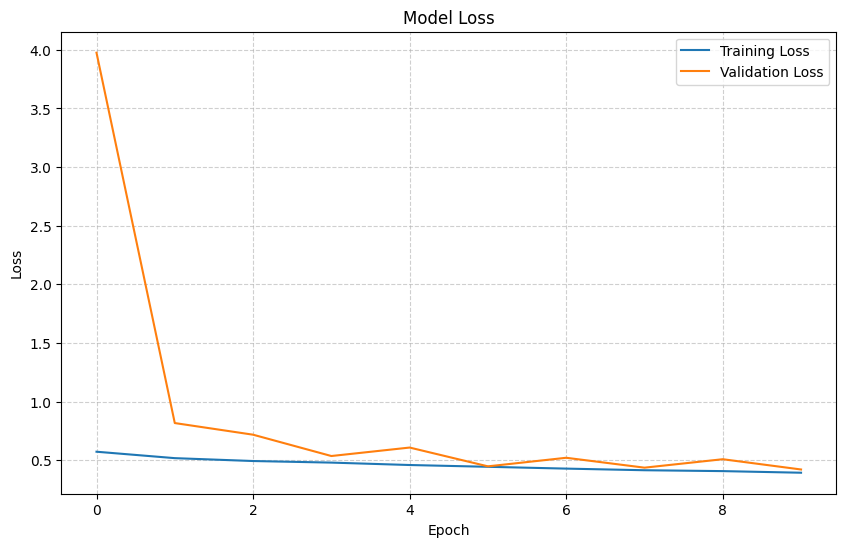

✔ Saved: plots/unet_plus_plus_model_accuracy.png


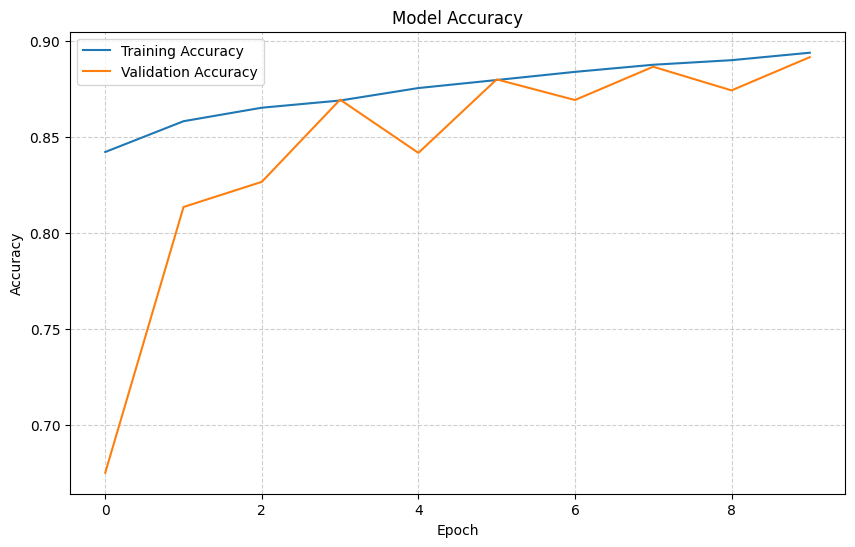

✔ Saved: plots/unet_plus_plus_model_iou.png


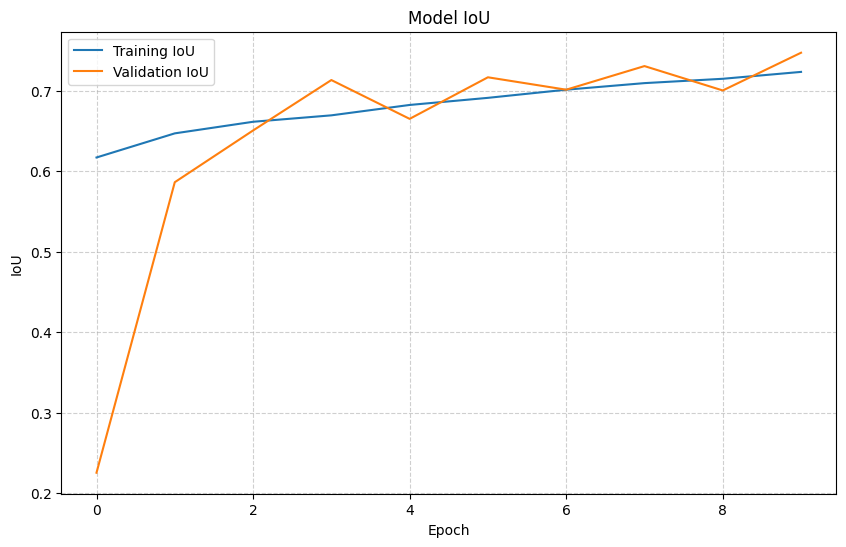

✔ Saved: plots/unet_plus_plus_model_dice_coefficient.png


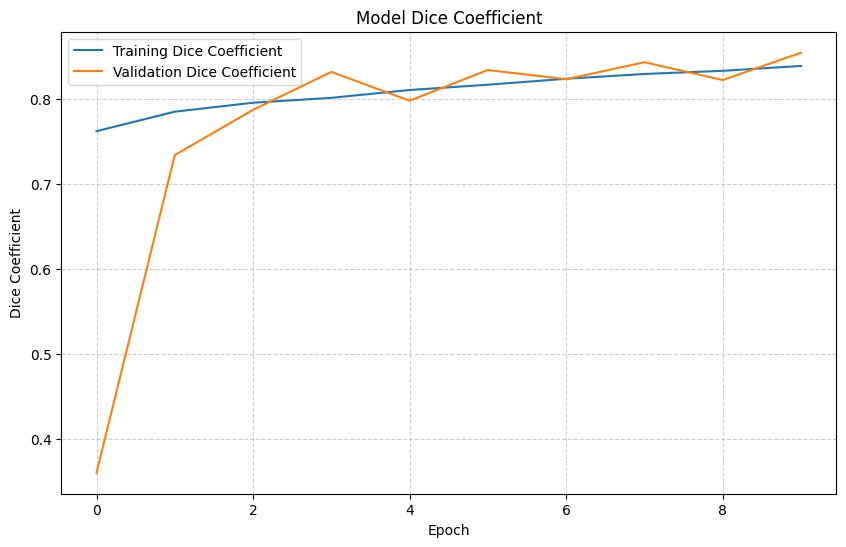

✔ Saved: plots/unet_plus_plus_model_precision.png


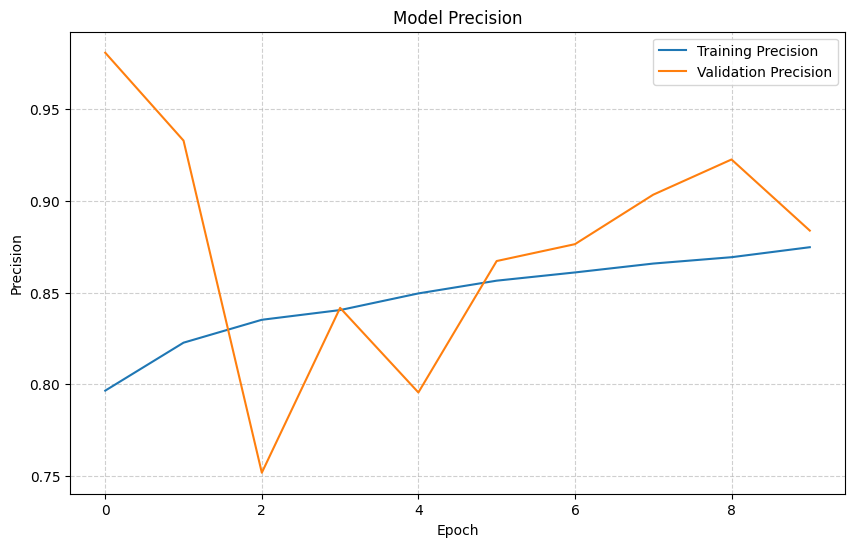

✔ Saved: plots/unet_plus_plus_model_recall.png


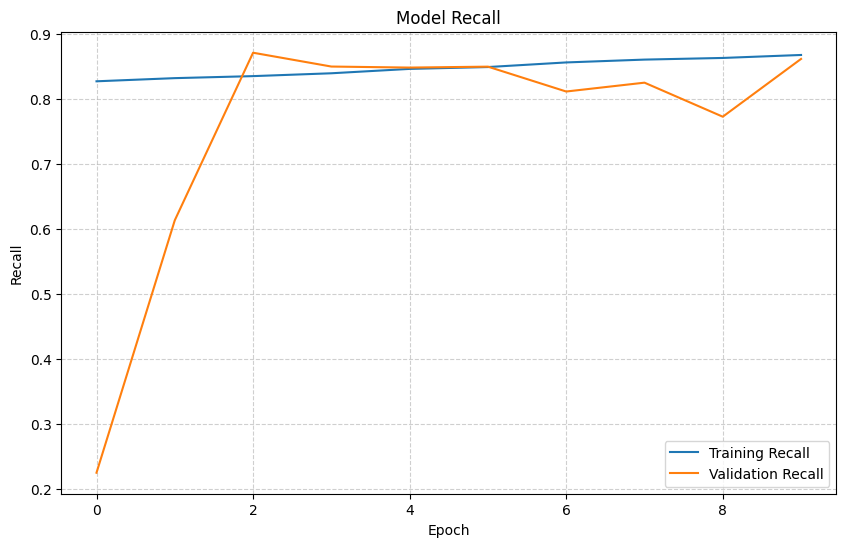

✔ Saved: plots/unet_plus_plus_model_f1-score.png


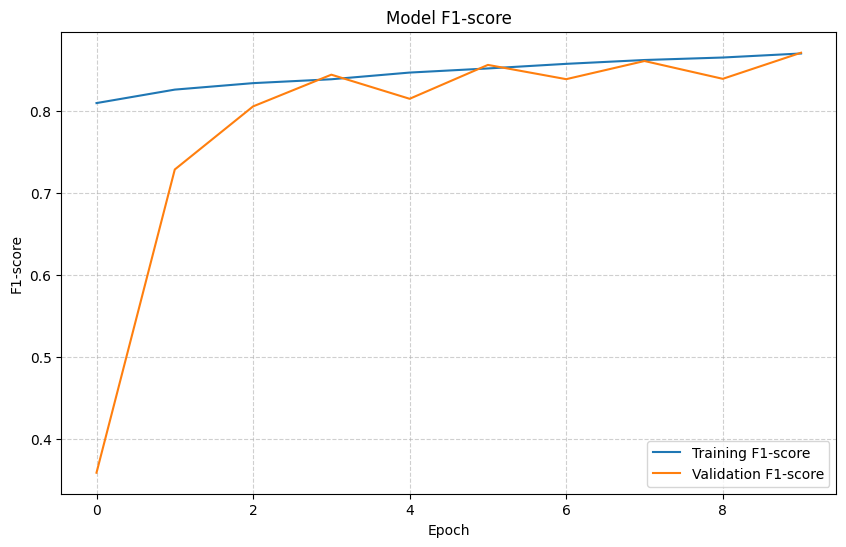

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
from tensorflow.keras import backend as K
import numpy as np # Ensure numpy is imported
import pandas as pd # Import pandas for df_processed creation
import glob # Import glob for df_processed creation
import math # Import math for dataset splitting

# Helper function to save figures (copied from a previous cell)
def save_fig(name, folder="plots"):
    os.makedirs(folder, exist_ok=True)
    plt.savefig(f"{folder}/{name}.png", dpi=300, bbox_inches="tight")
    print(f"✔ Saved: {folder}/{name}.png")

# Helper function for a convolution block (Conv2D -> BatchNorm -> ReLU)
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, 3, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# Helper function for concatenation and convolution in the decoder path
def concatenate_and_conv(input_tensors, num_filters):
    x = layers.Concatenate()(input_tensors)
    x = conv_block(x, num_filters)
    return x

def build_unet_plus_plus(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder path (X_i0 nodes)
    X_00 = conv_block(inputs, 32)
    p0 = layers.MaxPooling2D((2, 2))(X_00)

    X_10 = conv_block(p0, 64)
    p1 = layers.MaxPooling2D((2, 2))(X_10)

    X_20 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(X_20)

    X_30 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(X_30)

    # Bottleneck (X_40 node)
    X_40 = conv_block(p3, 512)

    # Decoder path with nested dense skip connections

    # Path j=1
    up_X40 = layers.UpSampling2D((2, 2))(X_40)
    X_31 = concatenate_and_conv([X_30, up_X40], 256)

    up_X30 = layers.UpSampling2D((2, 2))(X_30) # Defined here for X_21
    X_21 = concatenate_and_conv([X_20, up_X30], 128)

    up_X20 = layers.UpSampling2D((2, 2))(X_20) # Defined here for X_11
    X_11 = concatenate_and_conv([X_10, up_X20], 64)

    up_X10 = layers.UpSampling2D((2, 2))(X_10) # Defined here for X_01
    X_01 = concatenate_and_conv([X_00, up_X10], 32)


    # Path j=2
    up_X31 = layers.UpSampling2D((2, 2))(X_31) # Defined here for X_22
    X_22 = concatenate_and_conv([X_20, X_21, up_X31], 128)

    up_X21 = layers.UpSampling2D((2, 2))(X_21) # Defined here for X_12
    X_12 = concatenate_and_conv([X_10, X_11, up_X21], 64)

    up_X11 = layers.UpSampling2D((2, 2))(X_11) # Defined here for X_02
    X_02 = concatenate_and_conv([X_00, X_01, up_X11], 32) # Corrected concatenation


    # Path j=3
    up_X22 = layers.UpSampling2D((2, 2))(X_22) # Defined here for X_13
    X_13 = concatenate_and_conv([X_10, X_11, X_12, up_X22], 64)

    up_X12 = layers.UpSampling2D((2, 2))(X_12) # Defined here for X_03
    X_03 = concatenate_and_conv([X_00, X_01, X_02, up_X12], 32) # Corrected concatenation


    # Path j=4
    up_X13 = layers.UpSampling2D((2, 2))(X_13) # Defined here for X_04
    X_04 = concatenate_and_conv([X_00, X_01, X_02, X_03, up_X13], 32) # Corrected concatenation

    # Output layer (segmentation mask)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(X_04)

    model = models.Model(inputs, outputs)
    return model

# 1. Define a custom Dice Loss function
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# 2. Define additional metrics for segmentation
def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_val = true_positives / (predicted_positives + K.epsilon())
    return precision_val

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_val = true_positives / (possible_positives + K.epsilon())
    return recall_val

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))

print("Custom loss and metrics functions defined.")

# Ensure IMG_SIZE, BATCH_SIZE, EPOCHS are defined (from previous context or for robustness)
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10 # Using a smaller number of epochs for demonstration/faster execution

# --- Check for Google Drive mount ---
if not os.path.isdir('/content/drive'):
    print("ERROR: Google Drive is not mounted. Please run the cell 'from google.colab import drive; drive.mount('/content/drive')' first to mount your drive and access the dataset.")
    raise FileNotFoundError("Google Drive not mounted. Cannot proceed with data loading.")


# --- Re-create df_processed, dataset, and splits ---
# Define the path to the original images and the generated masks
image_dir = '/content/drive/MyDrive/HAM10000/images/'
mask_dir = '/content/drive/MyDrive/HAM10000/masks_grabcut_fast/'

# Re-initialize df if it's not in scope
data_path = "/content/drive/MyDrive/HAM10000"

try:
    df = pd.read_csv(os.path.join(data_path, "metadata.csv"))
except FileNotFoundError:
    print(f"ERROR: metadata.csv not found at {os.path.join(data_path, 'metadata.csv')}. Please ensure the file exists in your mounted Google Drive.")
    raise # Re-raise the exception to stop execution if file is critical

# Add 'path' column to df, as it's used in subsequent steps
image_folder = "/content/drive/MyDrive/HAM10000/images"
image_paths_dict = {
    os.path.splitext(os.path.basename(img))[0]: img
    for img in glob.glob(image_folder + "/*.jpg")
}
df["path"] = df["image_id"].map(image_paths_dict)
df = df.dropna(subset=["path"])

df_processed = df.copy()
df_processed['mask_path'] = df_processed['image_id'].apply(lambda x: os.path.join(mask_dir, f'{x}_mask.png'))
df_processed = df_processed[df_processed['mask_path'].apply(os.path.exists)]

print("df_processed re-created.")

def preprocess_image_mask(image_path, mask_path):
    # Read the image and mask files
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)

    # Decode image as JPEG (3 channels)
    image = tf.image.decode_jpeg(image, channels=3)
    # Decode mask as PNG (1 channel)
    mask = tf.image.decode_png(mask, channels=1)

    # Convert mask to tf.float32 and normalize to [0, 1]
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    # Ensure mask pixels are binary (0 or 1) after normalization
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    # Resize both image and mask to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])

    # Normalize image pixel values to tf.float32 and scale to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, mask

# Extract image and mask paths from the DataFrame
image_paths = df_processed['path'].values
mask_paths = df_processed['mask_path'].values

# Create a TensorFlow Dataset from these paths
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

# Apply the preprocessing function to each element in the dataset
dataset = dataset.map(preprocess_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the dataset for performance
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("TensorFlow Dataset re-created and preprocessed.")

# Calculate the total number of batches in the dataset
total_batches = tf.data.experimental.cardinality(dataset).numpy()

# Define the split ratios (e.g., 80% train, 10% validation, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of batches for each split
train_batches = math.floor(total_batches * train_ratio)
val_batches = math.floor(total_batches * val_ratio)
test_batches = total_batches - train_batches - val_batches # Ensure all batches are accounted for

# Split the dataset
train_dataset = dataset.take(train_batches)
val_dataset = dataset.skip(train_batches).take(val_batches)
test_dataset = dataset.skip(train_batches + val_batches).take(test_batches)

print("Dataset split into training, validation, and testing sets.")

# 1. Initialize empty lists
X_train_list = []
y_train_masks_list = []
X_val_list = []
y_val_masks_list = []
X_test_list = [] # Not strictly needed for training, but good for completeness
y_test_masks_list = [] # Not strictly needed for training, but good for completeness

# 2. Iterate through train_dataset
for images, masks in train_dataset:
    X_train_list.append(images.numpy())
    y_train_masks_list.append(masks.numpy())

# 3. Iterate through val_dataset
for images, masks in val_dataset:
    X_val_list.append(images.numpy())
    y_val_masks_list.append(masks.numpy())

# 4. Iterate through test_dataset (optional, but keeping it for consistency if needed later)
for images, masks in test_dataset:
    X_test_list.append(images.numpy())
    y_test_masks_list.append(masks.numpy())

# 5. Concatenate lists into single NumPy arrays
X_train = np.concatenate(X_train_list, axis=0)
y_train_masks = np.concatenate(y_train_masks_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_val_masks = np.concatenate(y_val_masks_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test_masks = np.concatenate(y_test_masks_list, axis=0)

print("Train/Validation/Test NumPy arrays re-created.")

# Instantiate the model
unet_plus_plus_model = build_unet_plus_plus(input_shape=(IMG_SIZE, IMG_SIZE, 3))

print("U-Net++ Model built and instantiated.")

# Compile the model
unet_plus_plus_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=bce_dice_loss, # Custom combined BCE and Dice Loss
    metrics=['accuracy', iou_metric, dice_coeff, precision, recall, f1_score]
)

print("U-Net++ model compiled successfully.")

# --- Training the model ---
history = unet_plus_plus_model.fit(
    X_train, y_train_masks,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_masks)
)

print("Model training complete.")

# --- Plotting training history ---

# Plot Model Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
save_fig('unet_plus_plus_model_loss')
plt.show()

# Plot Metrics
metrics_to_plot = {
    'Accuracy': ('accuracy', 'val_accuracy'),
    'IoU': ('iou_metric', 'val_iou_metric'),
    'Dice Coefficient': ('dice_coeff', 'val_dice_coeff'),
    'Precision': ('precision', 'val_precision'),
    'Recall': ('recall', 'val_recall'),
    'F1-score': ('f1_score', 'val_f1_score')
}

for metric_name, (train_metric_key, val_metric_key) in metrics_to_plot.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[train_metric_key], label=f'Training {metric_name}')
    plt.plot(history.history[val_metric_key], label=f'Validation {metric_name}')
    plt.title(f'Model {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    save_fig(f'unet_plus_plus_model_{metric_name.lower().replace(" ", "_")}')
    plt.show()